# Pre-trained Models: Resnet50 & VGG16

## Introduction:

There are many pretrained models(Xception, InceptionV3, ResNet50, VGG16, VGG19, MobileNet). In this notebook, I will use 2 pre-trained models: Resnet50 and VGG16 to evaluate face emotions.


#### VGG-16 (16 layers)

  VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous models submitted to ILSVRC-2014. VGG16 was trained for weeks and was using NVIDIA Titan Black GPUs.
  The input to the cov1 layer is of a fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional layers, where the filters were used with a very small receptive field: 3×3. Spatial pooling is carried out by five max-pooling layers, which follow some of the Conv. layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window with stride 2. All hidden layers are equipped with the rectification (ReLU) non-linearity. 
  
  
#### Resnet50

 The ResNet is also called as Residual network. It has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. Because of the framework that ResNets presented it was made possible to train ultra deep neural networks, network can contain hundreds or thousands of layers and still achieve great performance. The ResNet50 uses the concept of short cut or skipping in the convolutional neural network to carry out the task. ResNet50 uses only 98MB of disk space and accuracy varies between 75 percent to 92 percent for the ImageNet dataset. 
 
  
***layers***:
- Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if the new dataset differs a lot from the dataset that the original model was trained on, it is better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

## Links to this notebook:

* [Imports](#1.Imports)
* [Preprocessing](#2.Preprocessing)
* [Resnet50](#3.Resnet50)
* [VGG16](#4.VGG16)
* [Possible Fine-tuning](#5.Fine-tuning)
* [Conclusion](#6.Conclusion)
* [Referrences](#7.Referrences)

In [ ]:
# You might run this link if you wish.

# By default tensorflow takes %95 of memory using this code we will tell to use only 1/4
# It is useful if we need to run several models at the same time

# https://qastack.ru/programming/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
# https://medium.com/@harikrishnanrajeev/gpu-tips-and-tricks-16e95bfd726f

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.333
# session = InteractiveSession(config=config)

## 1.Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import ResNet50

from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

In [2]:
# Load the df's
df = pd.read_csv('./data/train.csv')
#test = pd.read_csv('./data/test.csv')

In [3]:
df.head(3)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...


## 2.Preprocessing

In [4]:
# function to convert 1d pixels to array
def converter(pixels):
    return np.array(pixels.split(),"float64")

In [5]:
# convert to array
df['pixels'] = df['pixels'].apply(converter)
# test['pixels'] = test['pixels'].apply(converter)

In [6]:
# Scale
df['pixels']/=255.
# test['pixels']/=255.

In [7]:
# reshape 
image = np.reshape(list(df.pixels),(df.shape[0],48,48))
# image_test = np.reshape(list(test.pixels),(test.shape[0],48,48))
image.shape

(28709, 48, 48)

In [8]:
# Since pretrained models were trained on color images, we need to transfer our greyimages to color too
# We will stack them on each other using repeat function
rgb = np.repeat(image[..., np.newaxis], 3, -1)
rgb.shape

(28709, 48, 48, 3)

In [9]:
# identify X, y and train_test_split
X = rgb   
y = to_categorical(df['emotion'])

X_train,X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

## 3.Resnet50


#### Tuning Resnet50:

- ***include_top (True)***: Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
- ***weights (‘imagenet‘)***: What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
- ***input_tensor (None)***: A new input layer if you intend to fit the model on new data of a different size.
- ***input_shape (None)***: The size of images that the model is expected to take if you change the input layer.
- ***pooling (None)***: The type of pooling to use when you are training a new set of output layers.
- ***classes (1000)***: The number of classes (e.g. size of output vector) for the model.

In [10]:
# Resnet was trained on 1000 objects
# Need to download weights from imagenet

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(48,48,3))

In [11]:
# loop over all layers and weights in the base model and freeze them so they will *not* be updated during the training process
for layer in resnet.layers:
    layer.trainable = False

In [21]:
# Set the model

rn = models.Sequential()

rn.add(resnet)

rn.add(layers.Flatten())

rn.add(Dense(512, activation = 'relu'))
rn.add(Dropout(0.1))
rn.add(Dense(7, activation = 'softmax'))

In [20]:
# 2nd way setting up the network

# x = resnet.output
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation = 'relu')(x)
# x = Dropout(0.4)(x)
# output = Dense(7, activation= 'softmax')(x)

# #Append both resnet and my Dense layers
# rn = Model(inputs = resnet.input, outputs = output)

In [22]:
# Let's look at our model's construction
rn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 3591      
Total params: 27,786,119
Trainable params: 4,198,407
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
#Instantiate data augmentation

resnet_train_datagen = ImageDataGenerator( rotation_range=40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)

resnet_test_datagen = ImageDataGenerator()

In [24]:
# Fit image generator on train and test

train_generator = resnet_train_datagen.flow(X_train, y_train, batch_size=100)
validation_generator = resnet_test_datagen.flow(X_val, y_val, batch_size=100)

In [25]:
# Compile the model

# opt = Adam(lr=0.0001)
rn.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= ['accuracy'])

In [26]:
# Fit resnet on data

history = rn.fit(train_generator,
                 steps_per_epoch= 215,
                 epochs=15,
                 validation_data=validation_generator,
                 validation_steps=71,
                 verbose = 0)

In [29]:
# Evaluation

rn.evaluate(X_val,y_val)

225/225 [==============================] - 36s 113ms/step - loss: 1.7582 - accuracy: 0.2609


[1.7582076787948608, 0.2609362006187439]

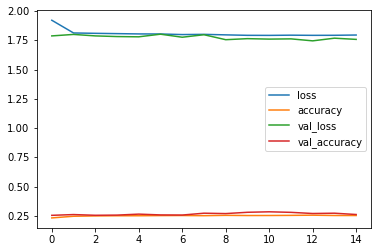

In [27]:
# Let's look at loss and accuracy together

for key in history.history.keys():
    plt.plot(history.history[key], label=key)

plt.title('Resnet50')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy and Loss',fontsize=16)
plt.legend();

## 4.VGG16

In [68]:
# Instantiate VGG16

vgg_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48, 3))

In [ ]:
# Freeze the vgg16 trainable layers:

# vgg_conv_base.trainable = False or
for layer in vgg_conv_base.layers:
    layer.trainable = False

In [ ]:
# look at the vgg_conv_base summary to check if layers are frozen
# vgg_conv_base.summary()

In [61]:
# Instantiate the model with VGG as a base and add custom layers after Flatten()

vgg = models.Sequential()
vgg.add(vgg_conv_base)
vgg.add(layers.Flatten())
vgg.add(layers.Dense(256, activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(7,activation='softmax'))

In [2]:
# Look at our model's structure
# vgg.summary()

In [39]:
# Instantiate ImageDataGenerator

train_datagen = ImageDataGenerator( rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_datagen = ImageDataGenerator()

In [40]:
# Fit datagen to X and y

train_generator = train_datagen.flow(X_train, y_train, batch_size=100)
validation_generator = test_datagen.flow(X_val, y_val, batch_size=100)

In [41]:
# Compile the model

vgg.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.0001), metrics= ['accuracy'])

In [42]:
# Fit and train the model

history1 = vgg.fit(train_generator,
                   steps_per_epoch= 215,
                   epochs=47,
                   validation_data=validation_generator,
                   validation_steps=50,
                   verbose =1)

Epoch 1/47
215/215 [==============================] - 188s 837ms/step - loss: 1.8298 - accuracy: 0.2369 - val_loss: 1.7228 - val_accuracy: 0.2916
Epoch 2/47
215/215 [==============================] - 186s 860ms/step - loss: 1.7625 - accuracy: 0.2730 - val_loss: 1.6880 - val_accuracy: 0.3138
Epoch 3/47
215/215 [==============================] - 185s 856ms/step - loss: 1.7396 - accuracy: 0.2901 - val_loss: 1.6817 - val_accuracy: 0.3216
Epoch 4/47
215/215 [==============================] - 186s 861ms/step - loss: 1.7258 - accuracy: 0.3028 - val_loss: 1.6556 - val_accuracy: 0.3412
Epoch 5/47
215/215 [==============================] - 186s 861ms/step - loss: 1.7147 - accuracy: 0.3053 - val_loss: 1.6592 - val_accuracy: 0.3378
Epoch 6/47
215/215 [==============================] - 185s 859ms/step - loss: 1.7053 - accuracy: 0.3128 - val_loss: 1.6514 - val_accuracy: 0.3468
Epoch 7/47
215/215 [==============================] - 188s 871ms/step - loss: 1.6999 - accuracy: 0.3177 - val_loss: 1.6299 -

In [43]:
# Evaluation

vgg.evaluate(X_val,y_val)

225/225 [==============================] - 53s 190ms/step - loss: 1.5687 - accuracy: 0.3888


[1.5686523914337158, 0.38882696628570557]

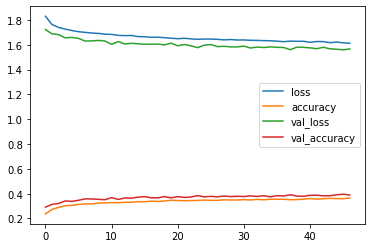

In [44]:
# Let's look at loss and accuracy together

for key in history1.history.keys():
    plt.plot(history1.history[key], label=key)
    
plt.title('VGG16')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy and Loss', fontsize=16)
plt.legend();

## 5.Fine-tuning

***Fine-tuning*** is a process of unfreezing a few of the top layers of a frozen pre-trained model and jointly training both the newly added Dense layers and these top layers. It is also possible to add input layers to the pre-trained model as well.

#### Fine-tuning steps:

- 1. Add your custom network on top of an already trained base network.
- 2. Freeze the base network.
- 3. Train the part you added.
- 4. Unfreeze some layers in the base network.
- 5. Jointly train both these layers and the part you added

In [80]:
# This is the summary of the VGG model. And, I will be unfreezing the block5_conv layers.

base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48, 3))

# base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [81]:
# Unfreezing top 2 layers

set_trainable = False

for layer in base.layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [82]:
# base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
# double check trainable weights
#print('Total trainable weights:{}'.format(len(base.trainable_weights)))base.trainable_weights

In [83]:
# Set the model

vgg_ft = models.Sequential()
vgg_ft.add(base)
vgg_ft.add(layers.Flatten())
vgg_ft.add(layers.Dense(256, activation='relu'))
vgg_ft.add(Dropout(0.2))
vgg_ft.add(Dense(7,activation='softmax'))

In [84]:
# Mr. Chollet recommends to lower the learning rate here to limit the magnitude of the modifications we make
# to the representations of the 3 layers that are fine-tuned. Updates that are too large may harm these representations.

# Train the model:

vgg_ft.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.00001), metrics= ['accuracy'])

history3 = vgg_ft.fit(train_generator,
                      steps_per_epoch= 215,
                      epochs=25,
                      validation_data=validation_generator,
                      validation_steps=50,
                      verbose =1)

Epoch 1/25
215/215 [==============================] - 481s 2s/step - loss: 1.8153 - accuracy: 0.2518 - val_loss: 1.6820 - val_accuracy: 0.3226
Epoch 2/25
215/215 [==============================] - 267s 1s/step - loss: 1.7160 - accuracy: 0.3105 - val_loss: 1.6195 - val_accuracy: 0.3642
Epoch 3/25
215/215 [==============================] - 259s 1s/step - loss: 1.6729 - accuracy: 0.3345 - val_loss: 1.5846 - val_accuracy: 0.3856
Epoch 4/25
215/215 [==============================] - 261s 1s/step - loss: 1.6558 - accuracy: 0.3381 - val_loss: 1.5587 - val_accuracy: 0.3922
Epoch 5/25
215/215 [==============================] - 262s 1s/step - loss: 1.6390 - accuracy: 0.3494 - val_loss: 1.5458 - val_accuracy: 0.3942
Epoch 6/25
215/215 [==============================] - 264s 1s/step - loss: 1.6232 - accuracy: 0.3609 - val_loss: 1.5293 - val_accuracy: 0.4056
Epoch 7/25
215/215 [==============================] - 263s 1s/step - loss: 1.6113 - accuracy: 0.3662 - val_loss: 1.5166 - val_accuracy: 0.4166

In [89]:
# # # Evaluate the model

test_generator = test_datagen.flow(X_val, y_val)
vgg_ft.evaluate(test_generator, steps=70)

70/70 [==============================] - 27s 162ms/step - loss: 1.4091 - accuracy: 0.4688


[1.4091339111328125, 0.46875]

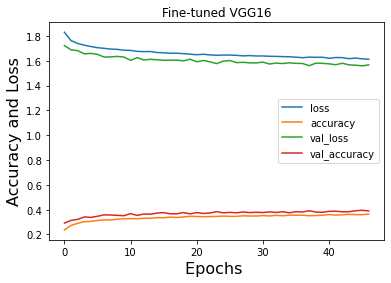

In [88]:
# Let's look at loss and accuracy together

for key in history2.history.keys():
    plt.plot(history2.history[key], label=key)
    
plt.title('Fine-tuned VGG16')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy and Loss', fontsize=16)
plt.legend();

## 6.Conclusion

- VGG seems to be a little bit faster and gives me a higher score than Resnet.
- Resnet achieved very quickly an accuracy score of 0.26 and didn't improve after that
- VGG improves slowly
- More experiments could to be done with the fine-tuning of higher layers of each pre-trained model
- Different pre-trained models could be used, such as VGGFace or other.

## 7.Referrences

[Resnet50 architecture](https://iq.opengenus.org/resnet50-architecture/)

[Facial Image Recognition Using Resnet50](https://www.sciencedirect.com/science/article/pii/S2666307421000073)

[Resnet50 and Emotion Detection from youtube](https://www.youtube.com/watch?v=3Eequbg2_C0)

[Scin Cancer and resnet50 Kaggle](https://www.kaggle.com/kocayinana/skin-cancer-recognition-with-resnet-50)

[Resnet50 and fine-tuning](https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/)

[Image Classifier using Resnet50 Deep Learning model](https://medium.com/@venkinarayanan/tutorial-image-classifier-using-resnet50-deep-learning-model-python-flask-in-azure-4c2b129af6d2)

[All models](https://www.mathworks.com/help/deeplearning/ref/resnet50.html)